<a href="https://colab.research.google.com/github/hafedh-hichri/bamboo-project2/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#guide 
# https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
# https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "/content/drive/MyDrive/Project 2" /content/

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
# import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from tqdm import tqdm
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
import zipfile
with zipfile.ZipFile("/content/Project 2/license_plates_detection_train.zip","r") as zip_ref:
    zip_ref.extractall("images/")
with zipfile.ZipFile("/content/Project 2/test.zip","r") as zip_ref:
    zip_ref.extractall("images/")

In [6]:
import os 
print(os.listdir('images/'))
# train and test images are in differant folders (not included in the github repo )
# i put them in the upper folder containing them


# IMPORTANT ! 
image_directory = "images/"   # change this to "./" if your images are in the same directory
train_location = "license_plates_detection_train/"
targetwidth = 224
targethight=224

['test_private', 'license_plates_detection_train']


In [8]:
import pandas as pd 
df = pd.read_csv("/content/Project 2/license_plates_detection_train.csv")
df.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [8]:
l = df.loc[0,:]
l

img_id    1.jpg
ymin        276
xmin         94
ymax        326
xmax        169
Name: 0, dtype: object

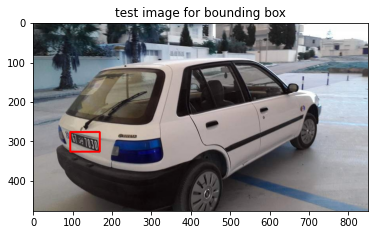

In [9]:
import cv2  #pip install opencv-python
import matplotlib.pyplot as plt 
img = cv2.imread(image_directory+train_location+"1.jpg")
cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
plt.imshow(img)
plt.title("test image for bounding box")
plt.show()

In [10]:
def convert_img_directory(img_name):
    return image_directory+train_location+img_name
def show_bb(line_from_df):
    l = df.iloc[line_from_df,:]
    #change this if the train and test folder are somewhere else
    img = cv2.imread(convert_img_directory(l[0]))
    cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
    plt.imshow(img)
    plt.title("test image for bounding box")
    plt.show()

In [11]:
len(df)

900

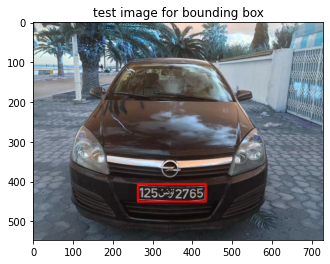

In [12]:
#pick any number under 900 from df
show_bb(2)

In [13]:
df.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [14]:
def path(p):
    return image_directory+train_location+p
df['img_id'] = df['img_id'].apply(path)

In [15]:
df.columns.to_list()

['img_id', 'ymin', 'xmin', 'ymax', 'xmax']

In [16]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(df)):
    image = df["img_id"][ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    ymin, xmin, ymax, xmax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [17]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [18]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((720, 224, 224, 3), (180, 224, 224, 3), (720, 4), (180, 4))

In [19]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=120,
                    validation_data=(x_test,y_test),callbacks=[tfb])

In [22]:
model.save('./model.h5')

In [5]:
# !cp drive/MyDrive/model.h5 model.h5

In [6]:
test = tf.keras.models.load_model('/content/model.h5')


In [49]:
def process_output(directory,model):
  # Prepprocesing
  load_image = load_img(image,target_size=(224,224))
  load_image_arr = img_to_array(load_image)
  img = load_image_arr/255.0 # Normalization
  X = np.array(img)
  X = X.reshape((-1, 224, 224, 3))
  #prediction
  l = model.predict(X)
  nxmin,nxmax,nymin,nymax = l[0]
  nxmin = int(nxmin*224)
  nxmax = int(nxmax*224)
  nymin = int(nymin*224)
  nymax = int(nymax*224)
  return img,nxmin,nxmax,nymin,nymax 

In [50]:
img,nxmin,nxmax,nymin,nymax  = process_output("./images/license_plates_detection_train/1.jpg",test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted')

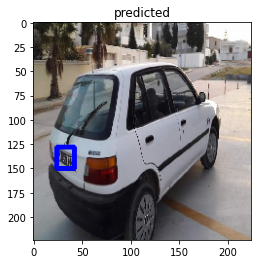

In [51]:
img1 = cv2.rectangle(img,(nxmin,nymin),(nxmax,nymax),(0,0,255),3)
plt.imshow(img1)
plt.title("predicted")